In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [2]:
# 하이퍼파라미터 설정
input_dim = 784   # 이미지 데이터 x의 크기 (MNIST 이미지는 28 X 28 = 784)
hidden_dim = 200  # 신경망 중간층의 차원 수
latent_dim = 20   # 잠재 변수 벡터 z의 차원 수
epochs = 30
learning_rate = 3e-4
batch_size = 32

In [3]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super().__init__()
    self.linear = nn.Linear(input_dim, hidden_dim)
    self.linear_mu = nn.Linear(hidden_dim, latent_dim)
    self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

  def forward(self, x):
    h = self.linear(x)
    h = F.relu(h)
    mu = self.linear_mu(h)
    logvar = self.linear_logvar(h)
    sigma = torch.exp(0.5 * logvar)
    return mu, sigma

In [4]:
class Decoder(nn.Module):
  def __init__(self, latent_dim, hidden_dim, output_dim):
    super().__init__()
    self.linear1 = nn.Linear(latent_dim, hidden_dim)
    self.linear2 = nn.Linear(hidden_dim, output_dim)

  def forward(self, z):
    h = self.linear1(z)
    h = F.relu(h)
    h = self.linear2(h)
    x_hat = F.sigmoid(h)
    return x_hat

In [5]:
def reparameterize(mu, sigma):
  eps = torch.randn_like(sigma)
  z = mu + eps * sigma
  return z

In [6]:
class VAE(nn.Module):
  def __init__(self, input_dim, hidden_dim, latent_dim):
    super().__init__()
    self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
    self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

  def get_loss(self, x):
    mu, sigma = self.encoder(x)
    z = reparameterize(mu, sigma)
    x_hat = self.decoder(z)

    batch_size = len(x)
    L1 = F.mse_loss(x_hat, x, reduction='sum')
    L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
    return (L1 + L2) / batch_size

In [7]:
# 데이터셋
transform = transforms.Compose([
    transforms.ToTensor(),            # 텐서로 변환 후
    transforms.Lambda(torch.flatten)  # 이미지 평탄화
])
dataset = datasets.MNIST(
    root='./content/drive/MyDrive/DLFS5/data',
    train=True,
    download=True,
    transform=transform
)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.8MB/s]


In [8]:
# 모델과 옵티마이저
model = VAE(input_dim, hidden_dim, latent_dim).cuda()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []

In [10]:
for epcoh in range(epochs):
  loss_sum = 0.0
  cnt = 0

  for x, label in dataloader:  # 데이터 로드
    x = x.cuda()
    optimizer.zero_grad()      # 옵티마이저의 기울기 초기화
    loss = model.get_loss(x)   # VAE의 손실 함수 계산
    loss.backward()            # 역전파(기울기 계산)
    optimizer.step()           # 매개변수 갱신

    loss_sum += loss.item()
    cnt += 1

  loss_avg = loss_sum / cnt
  losses.append(loss_avg)
  print(loss_avg)

44.93758353271485
42.98591015625
41.987773604329426
41.35066069539388
40.914214029947914
40.59476558024089
40.35630249023438
40.17471282145182
40.01119000854492
39.864419274902346
39.71831383463542
39.614135286458335
39.51669961344401
39.430258310953775
39.368975814819336
39.25417699991862
39.20813860880534
39.11998599650065
39.077019095865886
39.00796247965495
38.90586821492513
38.857965895589196
38.82670383707682
38.81208814086914
38.7515389058431
38.73829637858073
38.67949971923828
38.63117582600911
38.57654798685709
38.565958841959635


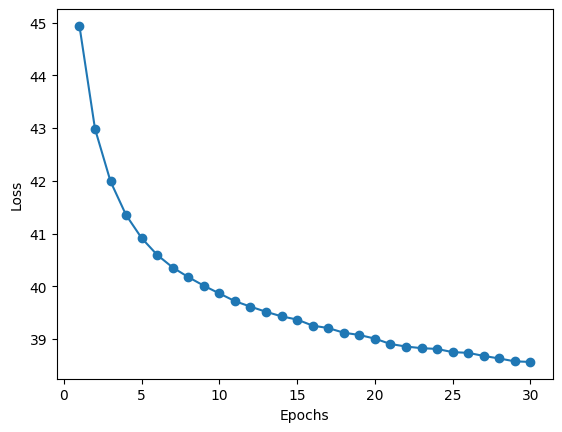

In [15]:
# 에포크별 손실 추이 시각화
epochs = list(range(1, epochs + 1))
plt.plot(epochs, losses, marker='o', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Grid image shpae: torch.Size([3, 242, 242])


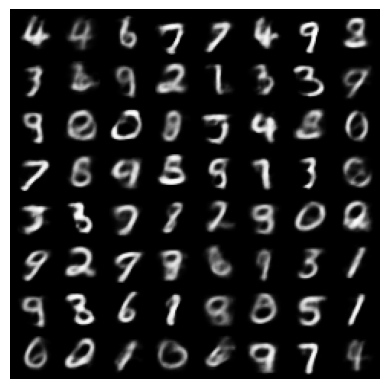

In [18]:
# 이미지 생성
with torch.no_grad():
  sample_size = 64
  z = torch.randn(sample_size, latent_dim).cuda()
  x = model.decoder(z)
  generated_images = x.view(sample_size, 1, 28, 28)

grid_img = torchvision.utils.make_grid(
    generated_images.cpu().detach(),
    nrow=8,
    padding=2,
    normalize=True
)

print(f'Grid image shpae:', grid_img.shape)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()